# Taxi Trajectory

#### We have provided with the dataset describing a complete year (from 1 july 2013 to 30 june 2014) of the trajectories for all the 442 taxies running in the city of portugal.
#### We are hired by the transportation industry of portugal and want to predict the total travel time of the trip based on the attributes given in the datasets.

## Data Overview

Each data point corresponds to one complete trip. It contains a total 9 features

* TRIP_ID (string) : It contains an unique identifier for each trip
* CALL_TYPE (char) :  It identifies the way used to demand this service. It may contain one of three possible values.
                      1. 'A' : if this trip was dispatched from the central
                      2. 'B' : if this trip was demanded directly to a taxi driver on a specific stand
                      3. 'C' : otherwise (i.e. a trip demanded on a random street)
* ORIGIN_CALL (integer) :  It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value
* ORIGIN_STAND (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value
* TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip
* TIMESTAMP (integer) : Unix Timestamp (in seconds). It identifies the trip’s start
* DAYTYPE (char) : It identifies the daytype of the trip’s start. It assumes one of three possible values
                    1. 'B' : if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.)
                    2. 'C' : if the trip started on a day before a type-B day
                    3. 'A' : otherwise (i.e. a normal day, workday or weekend)
* MISSING_DATA (Boolean) : It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing.
* POLYLINE (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string.The last list item corresponds to the trip’s destination while the first one represents its start. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The POLYLINE can have multiple pairs of longitude and latitude


The total travel time of the trip (the prediction target) is defined as the (number of points-1) x 15 seconds. For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. 




##### Type of Machine Learning task : 
It is an regression problem where given a set of features we need to predict the total travel time by taxi from starting of ride to the destination in seconds.
                    
                

#### Performace Metric
Since it is an regression problem we will use Root Mean Squared error (RMSE) and R-squared as regression metric.

#### Importing Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

from sklearn.externals import joblib

### EDA, Data Cleaning and Feature Engineering

#### Load the taxi trajectory data from CSV file

In [2]:
df = pd.read_csv('taxi-trajectory/train.csv')

In [3]:
df.shape

(1710670, 9)

The dataset has around 171K instances each of which has 9 different feature values.

In [4]:
df.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'],
      dtype='object')

Displying the first 10 rows.

In [5]:
df.head(10)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[..."
6,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-..."
7,1372637299620000011,C,NaN,NaN,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[..."
8,1372637274620000403,C,NaN,NaN,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[..."
9,1372637905620000320,C,NaN,NaN,20000320,1372637905,A,False,"[[-8.615907,41.140557],[-8.614449,41.141088],[..."


Filtering out categorical features.

In [6]:
df.dtypes[df.dtypes == 'object']

CALL_TYPE    object
DAY_TYPE     object
POLYLINE     object
dtype: object

In [7]:
df.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

There are many missing values in ORIGIN_CALL and ORIGIN_STAND because may be all the taxi users have not called the via phone and they have not started their trip from taxi stand.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
TRIP_ID         int64
CALL_TYPE       object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID         int64
TIMESTAMP       int64
DAY_TYPE        object
MISSING_DATA    bool
POLYLINE        object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [9]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


Describing the categorical features.

In [10]:
df.describe(include = ['object'])

,CALL_TYPE,DAY_TYPE,POLYLINE
count,1710670,1710670,1710670
unique,3,1,1703650
top,B,A,[]
freq,817881,1710670,5901


We can see the DAY_TYPE has only 1 unique value and that is 'A' which means that all the trips are started on normal day or weekend. Also the 5901 observations don't have the POLYLINE values means we cannot calculate the travel time for those trips.

##### Sorting the entire dataset based on the timestamp

In [11]:
df.sort_values('TIMESTAMP',inplace = True)

In [12]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-..."
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-..."


In [13]:
df['year'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).year) 
df['month'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).month) 
df['month_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).day) 
df['hour'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).hour) 
df['week_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).weekday()) 

In [14]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,5,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,5,0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,5,0
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,5,0
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,5,0


Pie chart for the year

([<matplotlib.patches.Wedge at 0x128df9c19e8>,
 [Text(-0.00339576,1.09999,'2013'), Text(0.00339576,-1.09999,'2014')],
 [Text(-0.00185223,0.599997,'50.1%'), Text(0.00185223,-0.599997,'49.9%')])

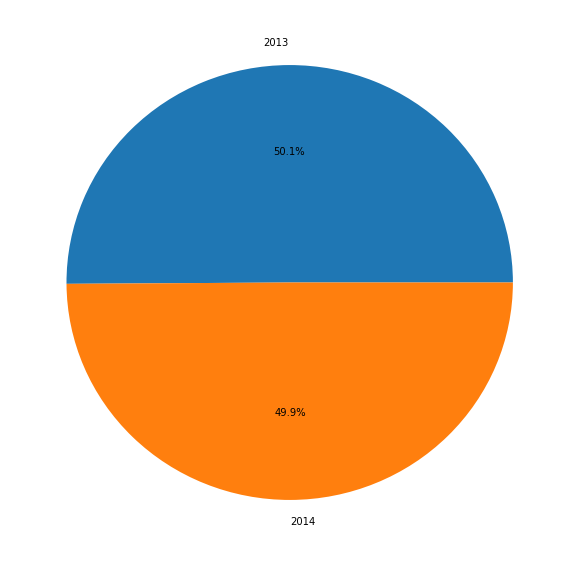

In [28]:
plt.figure(figsize = (10,10))
plt.pie(df['year'].value_counts(), labels = df['year'].value_counts().keys(),autopct = '%.1f%%')

From the above pie chart it is clear that there are equal number of taxi trips in both the year.

Text(0,0.5,'Day')

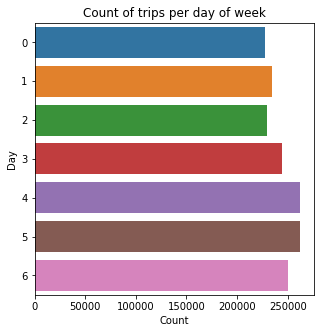

In [37]:
plt.figure(figsize = (5,5))
plt.title('Count of trips per day of week')
sns.countplot(y = 'week_day', data = df)
plt.xlabel('Count')
plt.ylabel('Day')

The 4th and 5th day of week has almost same number of trips and rest all the days have almost similar number of trips. This means that we can say each and every day of week required same number of taxies irrespective of weekend or working day.

Text(0,0.5,'Month')

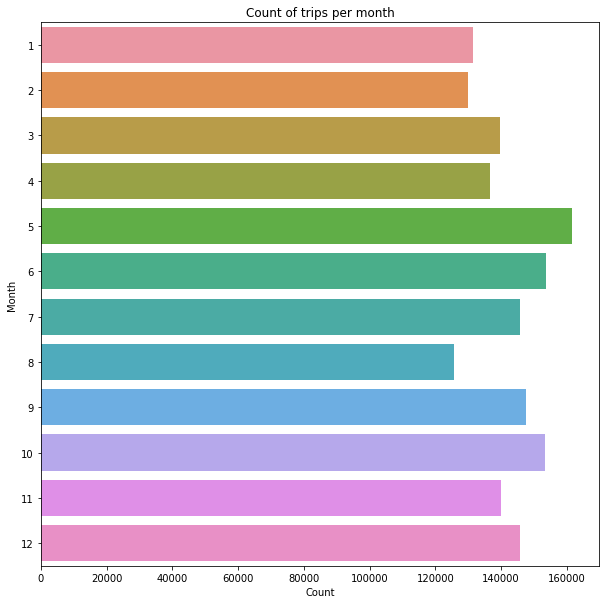

In [39]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per month')
sns.countplot(y = 'month', data = df)
plt.xlabel('Count')
plt.ylabel('Month')

On an average we can say that every month has atleast 120000 taxi trips planned.

Text(0,0.5,'Hours')

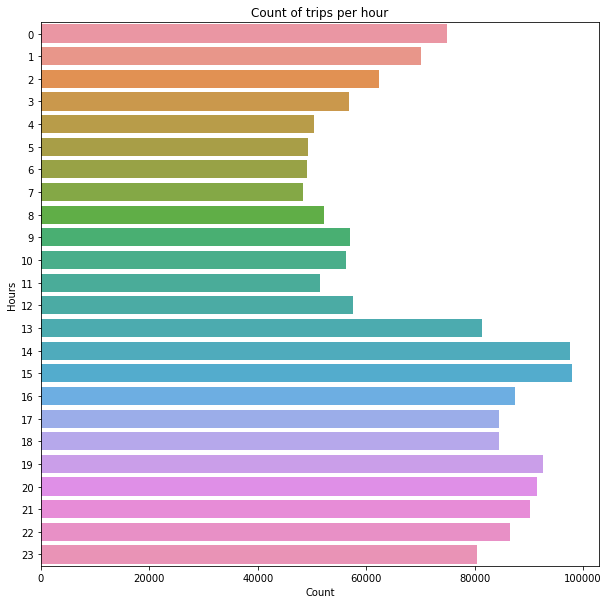

In [40]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per hour')
sns.countplot(y = 'hour', data = df)
plt.xlabel('Count')
plt.ylabel('Hours')

14th and 15th hour may be the peak hours, office time, school time because lot of taxies are used between this time.

In [41]:
df['MISSING_DATA'].value_counts()

False    1710660
True          10
Name: MISSING_DATA, dtype: int64

For 10 instances the GPS data steam is not complete and there can be one or more locations missing. Such a data points wont gives us the appropriate trip time so we can drop such observations.

In [44]:
df.drop(df[df['MISSING_DATA'] == True].index, inplace = True)

In [51]:
df['MISSING_DATA'].unique()

array([False])

Also some of the POLYLINES values are missing in which we cannot find the trip time, dropping such observations is also the good idea.

In [64]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

[]    5901
Name: POLYLINE, dtype: int64

In [65]:
df.drop(df[df['POLYLINE'] =='[]']['POLYLINE'].index, inplace = True)

In [67]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

Series([], Name: POLYLINE, dtype: int64)

#### Convreting a POLYLINE into the total travelling time.

In [164]:
df['Polyline Length'] = df['POLYLINE'].apply(lambda x : len(eval(x))-1)

In [178]:
df['Trip Time(sec)'] = df['Polyline Length'].apply(lambda x : x * 15)

In [179]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day,Polyline Length,Trip Time(sec)
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,5,0,24,360
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,5,0,42,630
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,5,0,22,330
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,5,0,21,315
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,5,0,42,630


In [180]:
df['Trip Time(sec)'].describe()

count    1.704759e+06
mean     7.189021e+02
std      6.846122e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.000000e+02
75%      8.700000e+02
max      5.820000e+04
Name: Trip Time(sec), dtype: float64

Above description clear that the minimum travelling time by the taxi is 15 seconds and maximum is 58200 seconds i.e.around 16 hours 16 min.

In [181]:
df.groupby('week_day').mean()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,year,month,month_day,hour,Polyline Length,Trip Time(sec)
week_day,,,,,,,,,,,,
0,1.388580e+18,24461.664648,29.588551,2.000034e+07,1.388580e+09,False,2013.492227,6.637702,15.836723,13.966295,49.777918,746.668773
1,1.388410e+18,24228.016897,30.360521,2.000035e+07,1.388410e+09,False,2013.480479,6.727104,15.452115,13.618647,48.860361,732.905422
2,1.388335e+18,24080.071729,30.163580,2.000034e+07,1.388335e+09,False,2013.507983,6.367314,15.463652,13.705219,49.758438,746.376565
3,1.388551e+18,23960.355688,30.168634,2.000035e+07,1.388551e+09,False,2013.505358,6.477834,15.569027,13.465996,49.183368,737.750523
4,1.388753e+18,24022.835850,30.087261,2.000035e+07,1.388753e+09,False,2013.506978,6.521286,15.980658,13.287886,50.056477,750.847154
5,1.388713e+18,25326.111877,30.260257,2.000035e+07,1.388712e+09,False,2013.494498,6.668749,15.733634,10.804929,45.099669,676.495029
6,1.388955e+18,25604.960314,31.331491,2.000036e+07,1.388955e+09,False,2013.504055,6.675327,14.867179,10.240593,43.200647,648.009705


On an average each day of week 648 to 750 seconds of journey were travelled.

In [187]:
df['DAY_TYPE'].isnull().sum()

0

#### One Hot Encoding for Call Type

In [188]:
df = pd.get_dummies(df, columns=['CALL_TYPE'])

#### Dropping the duplicates

In [193]:
df.shape

(1704759, 18)

In [196]:
df = df.drop_duplicates()
print(df.shape)

(1704757, 18)


There were 2 duplicate rows which was dropped.

#### Saving the final dataframe for future use.

In [ ]:
df.to_csv('Cleaned_data.csv', index = None)

#### Data Preparation for ML models.

In [4]:
df = df.iloc[:50000]

In [5]:
df.shape

(50000, 18)

In [6]:
X = df[['Polyline Length', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C']]
y = df['Trip Time(sec)']

#### Data Standardization

In [7]:
s = StandardScaler()
X = s.fit_transform(X)

In [8]:
print(np.mean(X))
np.std(X)

-6.821210263296962e-18


1.0

#### Train and Test splits : 70-30

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.3)

In [10]:
print("The size of training input is", X_train.shape)
print("The size of training output is", y_train.shape)
print(50 *'*')
print("The size of testing input is", X_test.shape)
print("The size of testing output is", y_test.shape)

The size of training input is (35000, 4)
The size of training output is (35000,)
**************************************************
The size of testing input is (15000, 4)
The size of testing output is (15000,)


### Machine Learning Models

#### 1. Baseline Model
* In baseline model the predicted trip time would be simply the average of all trip time.
* We will use this baseline model to perform hypothesis testing for other ML complex models.

In [38]:
y_train_pred = np.ones(X_train.shape[0]) * y_train.mean() #Predicting the train results

In [39]:
y_test_pred = np.ones(y_test.shape[0]) * y_train.mean() #Predicting the test results

In [42]:
print("Train Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  714.9990224927099
R-squared:  0.0


In [43]:
print("Test Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  609.6633604383986
R-squared:  -0.00022621499383568278


#### 2. KNN Regressor

In [44]:
k_range  =list(range(1,30)) 
param =dict(n_neighbors =k_range)
knn_regressor =GridSearchCV(KNeighborsRegressor(),param,cv =10)
knn_regressor.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')


{'n_neighbors': 1}

In [46]:
y_train_pred =knn_regressor.predict(X_train) ##Predict train result
y_test_pred =knn_regressor.predict(X_test) ##Predict test result

In [47]:
print("Train Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [48]:
print("Test Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  18.500540532643903
R-squared:  0.9990789422174107


We can see that the training RMSE error is low but testing RMSE error is high which means that model is overfitting.

#### 3. Ridge Regressor

In [22]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor =GridSearchCV(Ridge(), params ,cv =5,scoring = 'neg_mean_absolute_error', n_jobs =-1)
ridge_regressor.fit(X_train ,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [23]:
print(ridge_regressor.best_estimator_)
ridge_regressor.best_params_

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


{'alpha': 0.0001}

In [24]:
y_train_pred =ridge_regressor.predict(X_train) ##Predict train result
y_test_pred =ridge_regressor.predict(X_test) ##Predict test result

In [25]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  1.935114105538708e-06
R-squared:  1.0


In [26]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  1.8372585326207442e-06
R-squared:  1.0


#### 4. Lasso Regression

In [19]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor =GridSearchCV(Lasso(), params ,cv =15,scoring = 'neg_mean_absolute_error', n_jobs =-1)
lasso_regressor.fit(X_train ,y_train)

GridSearchCV(cv=15, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [20]:
print(lasso_regressor.best_estimator_)
lasso_regressor.best_params_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


{'alpha': 0.0001}

In [24]:
y_train_pred =lasso_regressor.predict(X_train) ##Predict train result
y_test_pred =lasso_regressor.predict(X_test) ##Predict test result

In [25]:
print("Train Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  9.744341385024548e-05
R-squared:  0.9999999999999808


In [26]:
print("Test Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  8.886823512747736e-05
R-squared:  0.9999999999999808


#### 5. Decision Tree Regressor

In [10]:
depth  =list(range(3,30))
param_grid =dict(max_depth =depth)
tree =GridSearchCV(DecisionTreeRegressor(),param_grid,cv =10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
print(tree.best_estimator_)
tree.best_params_

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


{'max_depth': 11}

In [12]:
y_train_pred =tree.predict(X_train) ##Predict train result
y_test_pred =tree.predict(X_test) ##Predict test result

In [13]:
print("Train Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [14]:
print("Test Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  27.767426960379314
R-squared:  0.9982704713930455


#### 6. XGBoost

In [12]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [13]:
print(model.best_estimator_)
model.best_params_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


{'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [15]:
print("Train Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  1.3721829907567928
R-squared:  0.9999963390152034


In [16]:
print("Test Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  13.848809726530913
R-squared:  0.9994736301420746


#### 7. Random Forest Regressor

In [24]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
random_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [25]:
print(random_regressor.best_estimator_)
random_regressor.best_params_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [26]:
y_train_pred = random_regressor.predict(X_train)
y_test_pred = random_regressor.predict(X_test)

In [27]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  17.825188359052866
R-squared:  0.9993372820716228


In [28]:
print("Test Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  15.6630775711544
R-squared:  0.9994496858611573


#### 8. Stacking

In stacking method we stack many different ML models to get the better results.

In [17]:
# Initializing models
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()

stack = StackingRegressor(regressors = [ridge, lasso, knn], meta_regressor = tree)
stack.fit(X_train, y_train)

StackingRegressor(meta_regressor=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         refit=True,
         regressors=[Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [18]:
print(stack.regr_)
stack.meta_regr_

[Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')]


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [19]:
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

In [20]:
print("Train Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [21]:
print("Test Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  52.07470595212229
R-squared:  0.9937699698482115


From the above all the models that we have trained most of them are overfitted including some ensemble teachniques also. But the random forest algorithm gives pretty good results. So the random forest is the best suited model for this dataset.

#### Save the winnig model to disk

In [30]:
win_model = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'winnig_model_random_forest.pkl')

['winnig_model_random_forest.pkl']